# Overview

The purpose of this Women in Data Science (WiDS) Datathon 2024 Challenge #2 is to predict the time to diagnosis of metastatic cancer in the United States. 

Training and test datasets have been provided (*train.csv* and *test.csv*) and contain both numerical and categorical variables.

The submission template (*solution_template.csv*) includes the patient id's in the test dataset and the integer target variable *metastatic_diagnosis_period* (where the measurement unit is days).


Thanks to @thiagomantuiani for sharing his Get started code, we used it as a starting point.

# Import libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import optuna
import warnings
import re
import scipy
from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config
from colorama import Style, Fore
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer,mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, HistGradientBoostingClassifier
import math
import os

Set palettes:

In [24]:
sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

Set options

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

Turn off runtime and future warnings:

In [25]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Import data

Import train and test datasets and the submission file.

In [26]:
train = pd.read_csv(r'/kaggle/input/widsdatathon2024-challenge2/train.csv', index_col='patient_id')
test = pd.read_csv(r'/kaggle/input/widsdatathon2024-challenge2/test.csv', index_col='patient_id')
sub  = pd.read_csv(r'/kaggle/input/widsdatathon2024-challenge2/solution_template.csv')

# Data Exploration

Explore the datasets by showing the top 5 rows and column names:

In [27]:
train.head()

,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
patient_id,,,,,,,,,,,,,,,,,,,,,
268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,C50912,...,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,C50412,...,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71,33
277055,NaN,COMMERCIAL,CA,925,West,Pacific,59,F,NaN,1749,...,68.50,70.31,78.61,87.24,85.52,80.75,70.81,62.67,55.58,157
320055,Hispanic,MEDICAID,CA,900,West,Pacific,59,F,NaN,C50911,...,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46,146
190386,NaN,COMMERCIAL,CA,934,West,Pacific,71,F,NaN,1748,...,59.45,60.24,64.77,69.81,70.13,68.10,65.38,60.72,54.08,286


In [28]:
#train_columns = train.columns
train_columns = train.columns.tolist()
print(train_columns)

['patient_race', 'payer_type', 'patient_state', 'patient_zip3', 'Region', 'Division', 'patient_age', 'patient_gender', 'bmi', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married', 'widowed', 'family_size', 'family_dual_income', 'income_household_median', 'income_household_under_5', 'income_household_5_to_10', 'income_household_10_to_15', 'income_household_15_to_20', 'income_household_20_to_25', 'income_household_25_to_35', 'income_household_35_to_50', 'income_household_50_to_75', 'income_household_75_to_100', 'income_household_100_to_150', 'income_household_150_over', 'income_household_six_figure', 'income_individual_median', 'home_ownership', 'housing_units'

In [29]:
test.head()

,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,...,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18
patient_id,,,,,,,,,,,,,,,,,,,,,
730681,NaN,COMMERCIAL,LA,713,South,West South Central,55,F,NaN,1746,...,62.21,62.23,78.34,81.96,83.58,82.22,80.20,69.73,53.14,51.34
334212,Black,NaN,NC,283,South,South Atlantic,60,F,40.00,C50912,...,48.63,58.14,77.26,80.05,82.88,82.09,78.85,64.60,50.57,48.10
571362,NaN,COMMERCIAL,TX,794,South,West South Central,54,F,32.33,1742,...,57.82,59.95,77.79,82.45,82.44,80.77,72.16,59.31,48.25,42.13
907331,NaN,COMMERCIAL,TN,373,South,East South Central,63,F,27.07,1748,...,47.57,53.50,71.31,75.20,76.96,75.78,74.87,61.06,44.31,42.83
208382,Asian,NaN,WA,980,West,Pacific,62,F,NaN,C50411,...,41.02,46.25,56.92,57.88,66.16,65.21,57.52,49.53,43.75,38.33


In [30]:
test_columns = test.columns.tolist()
print(test_columns)

['patient_race', 'payer_type', 'patient_state', 'patient_zip3', 'Region', 'Division', 'patient_age', 'patient_gender', 'bmi', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married', 'widowed', 'family_size', 'family_dual_income', 'income_household_median', 'income_household_under_5', 'income_household_5_to_10', 'income_household_10_to_15', 'income_household_15_to_20', 'income_household_20_to_25', 'income_household_25_to_35', 'income_household_35_to_50', 'income_household_50_to_75', 'income_household_75_to_100', 'income_household_100_to_150', 'income_household_150_over', 'income_household_six_figure', 'income_individual_median', 'home_ownership', 'housing_units'

In [31]:
sub.head()

,patient_id,metastatic_diagnosis_period
0,730681,100
1,334212,0
2,571362,100
3,907331,100
4,208382,100


## Data types

Print the name and type of all features (variables) in the training dataset. 

The feature types can be interpreted as follows:
- *object:* categorical 
- *int64:* numeric (integer)
- *float64:* numeric (floating number, not necessarily integer)

In [32]:
for column_name, dtype in train.dtypes.items():
    print(f"{column_name}: {dtype}")

patient_race: object
payer_type: object
patient_state: object
patient_zip3: int64
Region: object
Division: object
patient_age: int64
patient_gender: object
bmi: float64
breast_cancer_diagnosis_code: object
breast_cancer_diagnosis_desc: object
metastatic_cancer_diagnosis_code: object
metastatic_first_novel_treatment: object
metastatic_first_novel_treatment_type: object
population: float64
density: float64
age_median: float64
age_under_10: float64
age_10_to_19: float64
age_20s: float64
age_30s: float64
age_40s: float64
age_50s: float64
age_60s: float64
age_70s: float64
age_over_80: float64
male: float64
female: float64
married: float64
divorced: float64
never_married: float64
widowed: float64
family_size: float64
family_dual_income: float64
income_household_median: float64
income_household_under_5: float64
income_household_5_to_10: float64
income_household_10_to_15: float64
income_household_15_to_20: float64
income_household_20_to_25: float64
income_household_25_to_35: float64
income_hou

## Size

Check the size of the dataset with the *shape* method.

In [33]:
train.shape

(13173, 151)

In [34]:
test.shape

(5646, 150)

As expected, the test dataset has one column less than that training dataset as the target variable is not included.

In [35]:
print('The number of rows in the test dataset is', round(test.shape[0]/train.shape[0]*100,1), '% of the training dataset. \n\nNote that during the competition the leaderboard is calculated with approximately 52% of the test data. After the competition closes, the final standings will be computed based on the other 48%.')

The number of rows in the test dataset is 42.9 % of the training dataset. 

Note that during the competition the leaderboard is calculated with approximately 52% of the test data. After the competition closes, the final standings will be computed based on the other 48%.


Split variables to numeric and categorical ones:

## Missing values

Check missing or null values:

In [36]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = round(desc['nunique'] /len(train) * 100,1)
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc = pd.concat([desc,train.describe().T.drop('count',axis=1)],axis=1)

desc.sort_values(by=['type','null']).style.background_gradient(cmap='YlOrBr')

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
patient_zip3,int64,13173,751,5.700000,0,0.000000,568.530859,275.758485,100.000000,330.000000,557.000000,832.000000,995.000000
patient_age,int64,13173,67,0.500000,0,0.000000,59.271313,13.218883,18.000000,50.000000,59.000000,67.000000,91.000000
metastatic_diagnosis_period,int64,13173,366,2.800000,0,0.000000,96.515221,108.969873,0.000000,3.000000,44.000000,181.000000,365.000000
population,float64,13173,751,5.700000,0,0.000000,20651.373928,13840.379638,635.550000,9160.340000,18952.780000,30021.280000,71374.130000
density,float64,13173,747,5.700000,0,0.000000,1776.872376,3876.061897,0.920000,163.150000,700.340000,1666.520000,29851.690000
age_median,float64,13173,594,4.500000,0,0.000000,40.542676,4.031027,20.600000,37.190000,40.640000,42.940000,54.570000
age_under_10,float64,13173,450,3.400000,0,0.000000,11.104988,1.511534,0.000000,10.150000,11.000000,12.140000,17.680000
age_10_to_19,float64,13173,472,3.600000,0,0.000000,12.857587,1.952248,6.310000,11.650000,12.900000,13.910000,35.300000
age_20s,float64,13173,519,3.900000,0,0.000000,13.297375,3.390472,5.930000,11.000000,12.530000,14.970000,62.100000
age_30s,float64,13173,457,3.500000,0,0.000000,12.893557,2.410845,1.500000,11.270000,12.400000,14.130000,25.470000


- High number of **null values**. What draws the most attention is 'bmi' which contains 69% of null data.
- Dataset with **many columns (150)**, it may be possible to select features.
- **Discrepant values** in some attributes, such as 'home_value'.
- **11 categorical variables**, 4 of which have a high cardinality (between 43 and 47 possible values)
- **Patient Age Distribution:** The median patient age is 59 years, the inter-quartile range is 50-67 years.

- **Gender and Marital Status:** All patients are females, as expected.



# Geospatial mapping of location data

In [37]:
TARGET = 'metastatic_diagnosis_period'
train_location = train[['patient_state', 'patient_zip3', 'Region','Division', TARGET]]

In [38]:
print(train_location.head())

           patient_state  patient_zip3   Region            Division  \
patient_id                                                            
268700                AR           724    South  West South Central   
484983                IL           629  Midwest  East North Central   
277055                CA           925     West             Pacific   
320055                CA           900     West             Pacific   
190386                CA           934     West             Pacific   

            metastatic_diagnosis_period  
patient_id                               
268700                              191  
484983                               33  
277055                              157  
320055                              146  
190386                              286  


In [45]:
print(us_states.head())

  STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry  
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...  
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  
2  POLYGON ((-103.00257 36.52659, -103.00219 36.6...  
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...  
4  POLYGON ((-82.64320 38.16909, -82.64300 38.169...  


# By State

Calculate average TARGET by patient_state in the training dataset and ensure that patient_state is upper case:


In [46]:
avg_target = train.groupby('patient_state')[TARGET].mean().reset_index()
avg_target['patient_state'] = avg_target['patient_state'].str.upper()
print(avg_target.head())

  patient_state  metastatic_diagnosis_period
0            AK                    94.142857
1            AL                   107.300000
2            AR                    99.296296
3            AZ                   106.246914
4            CA                    93.758519


Loaded the US states shape file from a file shared by Nick Switzer.
Note that loading the US states from the built in 'naturalearth_lowres' geopandas dataset did not work out as it contains countries only (could be used for country level geospatial mapping).

In [47]:
#us_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#us_states = us_states[us_states['continent'] == 'North America']

us_states = gpd.read_file(r'/kaggle/input/usa-state-shapeflies/cb_2018_us_state_500k.shp')
us_states = us_states.rename(columns={'STUSPS': 'patient_state'}) 

In [48]:
print(us_states.head())

  STATEFP   STATENS     AFFGEOID GEOID patient_state            NAME LSAD  \
0      28  01779790  0400000US28    28            MS     Mississippi   00   
1      37  01027616  0400000US37    37            NC  North Carolina   00   
2      40  01102857  0400000US40    40            OK        Oklahoma   00   
3      51  01779803  0400000US51    51            VA        Virginia   00   
4      54  01779805  0400000US54    54            WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry  
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...  
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  
2  POLYGON ((-103.00257 36.52659, -103.00219 36.6...  
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...  
4  POLYGON ((-82.64320 38.16909, -82.64300 38.169...  


Merge the average TARGET with the state geometries:

In [50]:
merged = us_states.merge(avg_target, on='patient_state', how='left')
print(merged.head())

  STATEFP   STATENS     AFFGEOID GEOID patient_state            NAME LSAD  \
0      28  01779790  0400000US28    28            MS     Mississippi   00   
1      37  01027616  0400000US37    37            NC  North Carolina   00   
2      40  01102857  0400000US40    40            OK        Oklahoma   00   
3      51  01779803  0400000US51    51            VA        Virginia   00   
4      54  01779805  0400000US54    54            WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry  \
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...   
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...   
2  POLYGON ((-103.00257 36.52659, -103.00219 36.6...   
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...   
4  POLYGON ((-82.64320 38.16909, -82.64300 38.169...   

   meta

Plot target (metastatic diagnosis period) by US state:

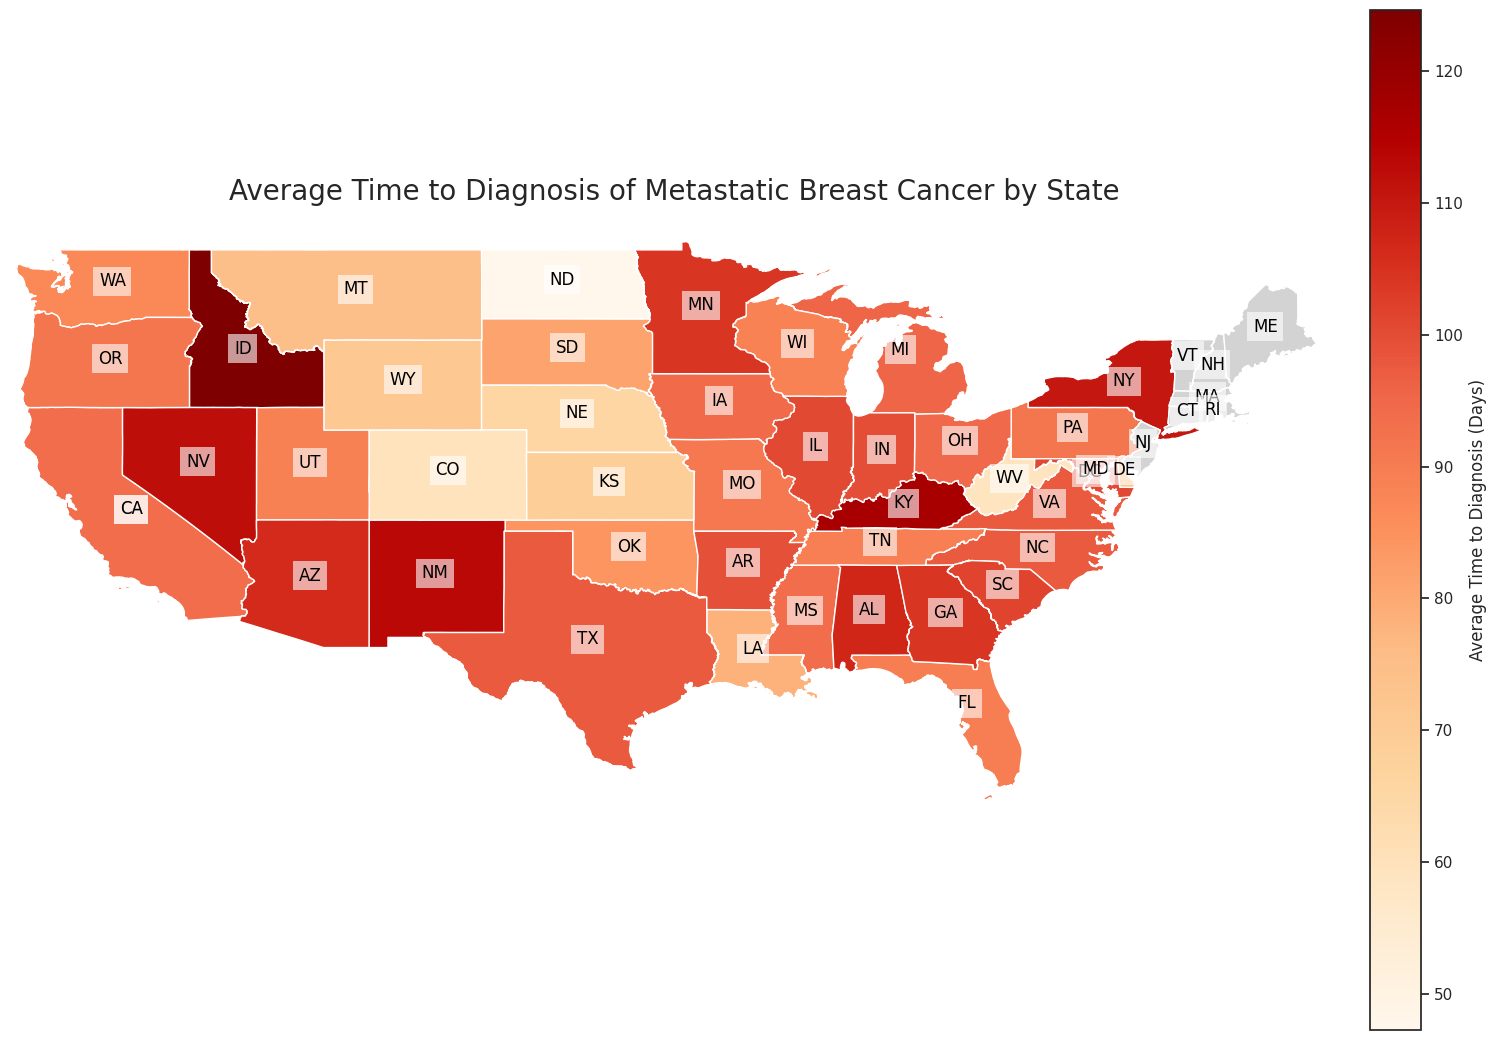

In [147]:
import matplotlib as mpl

# Set up the figure and axis with a large size
fig, ax = plt.subplots(1, 1, figsize=(20, 12))  # Large figure size

# Set custom x and y limits for the contiguous US
ax.set_xlim([-125, -66])  # Approximate longitude bounds for the US
ax.set_ylim([24, 50])     # Approximate latitude bounds for the US

# Plot the states and color by the TARGET variable
merged.plot(column= TARGET, ax=ax, legend=False,
            cmap='OrRd', missing_kwds={'color': 'lightgrey', 'label': 'No Data'})

# Set the aspect ratio to equal to maintain the correct proportions
ax.set_aspect('equal')

# Add title above the map
ax.set_title('Average Time to Diagnosis of Metastatic Breast Cancer by State', fontsize=20, pad=20)
ax.set_axis_off()

# Add state labels at each centroid with a larger font size
for _, row in merged.iterrows():
    state_name = row['patient_state']  # Adjust if your column has a different name
    centroid = row['geometry'].centroid
    # Only add labels for states within the specified x and y limits
    if ax.get_xlim()[0] < centroid.x < ax.get_xlim()[1] and ax.get_ylim()[0] < centroid.y < ax.get_ylim()[1]:
        ax.text(centroid.x, centroid.y, state_name, fontsize=12, ha='center', color='black', 
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Create a color bar beside the map
norm = mpl.colors.Normalize(vmin=merged[TARGET].min(), vmax=merged[TARGET].max())
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='OrRd'), ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("Average Time to Diagnosis (Days)", fontsize=12)

# Show the plot without tight layout to prevent resizing
plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.05)
plt.show()

Create geospatial data for the test dataset and plot it:

# By Division

Calculate average by Division and a mapping:

In [113]:
avg_division_target = train.groupby('Division')[TARGET].mean().reset_index()

Map Divisions to states:

In [114]:
state_to_division = {
    'East North Central': ['IL', 'IN', 'MI', 'OH', 'WI'],
    'East South Central': ['AL', 'KY', 'MS', 'TN'],
    'Middle Atlantic': ['NY', 'PA'],
    'Mountain': ['AZ', 'CA', 'CO', 'ID', 'MT', 'NM', 'NV', 'UT', 'WY'],
    'Pacific': ['AK', 'CA', 'HI', 'OR', 'WA'],
    'South Atlantic': ['DC', 'DE', 'FL', 'GA', 'MD', 'NC', 'SC','VA', 'WV'],
    'West North Central': ['IA', 'KS', 'MN', 'MO', 'ND', 'NE', 'SD'],
    'West South Central': ['AR', 'LA', 'OK', 'TX']
}

division_to_states = {state: division for division, states in state_to_division.items() for state in states}

us_states['Division'] = us_states['patient_state'].map(division_to_states)

# Dissolve the GeoDataFrame by Division
divisions_geo = us_states.dissolve(by='Division', as_index=False)

# Create map by division using avg_division_target 
merged_division_map = divisions_geo.merge(avg_division_target, on='Division', how='left')

In [115]:
us_states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,patient_state,NAME,LSAD,ALAND,AWATER,geometry,Division
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",East South Central
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",South Atlantic
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",West South Central
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",South Atlantic
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",South Atlantic


Plot target (metastatic diagnosis period) by Division:

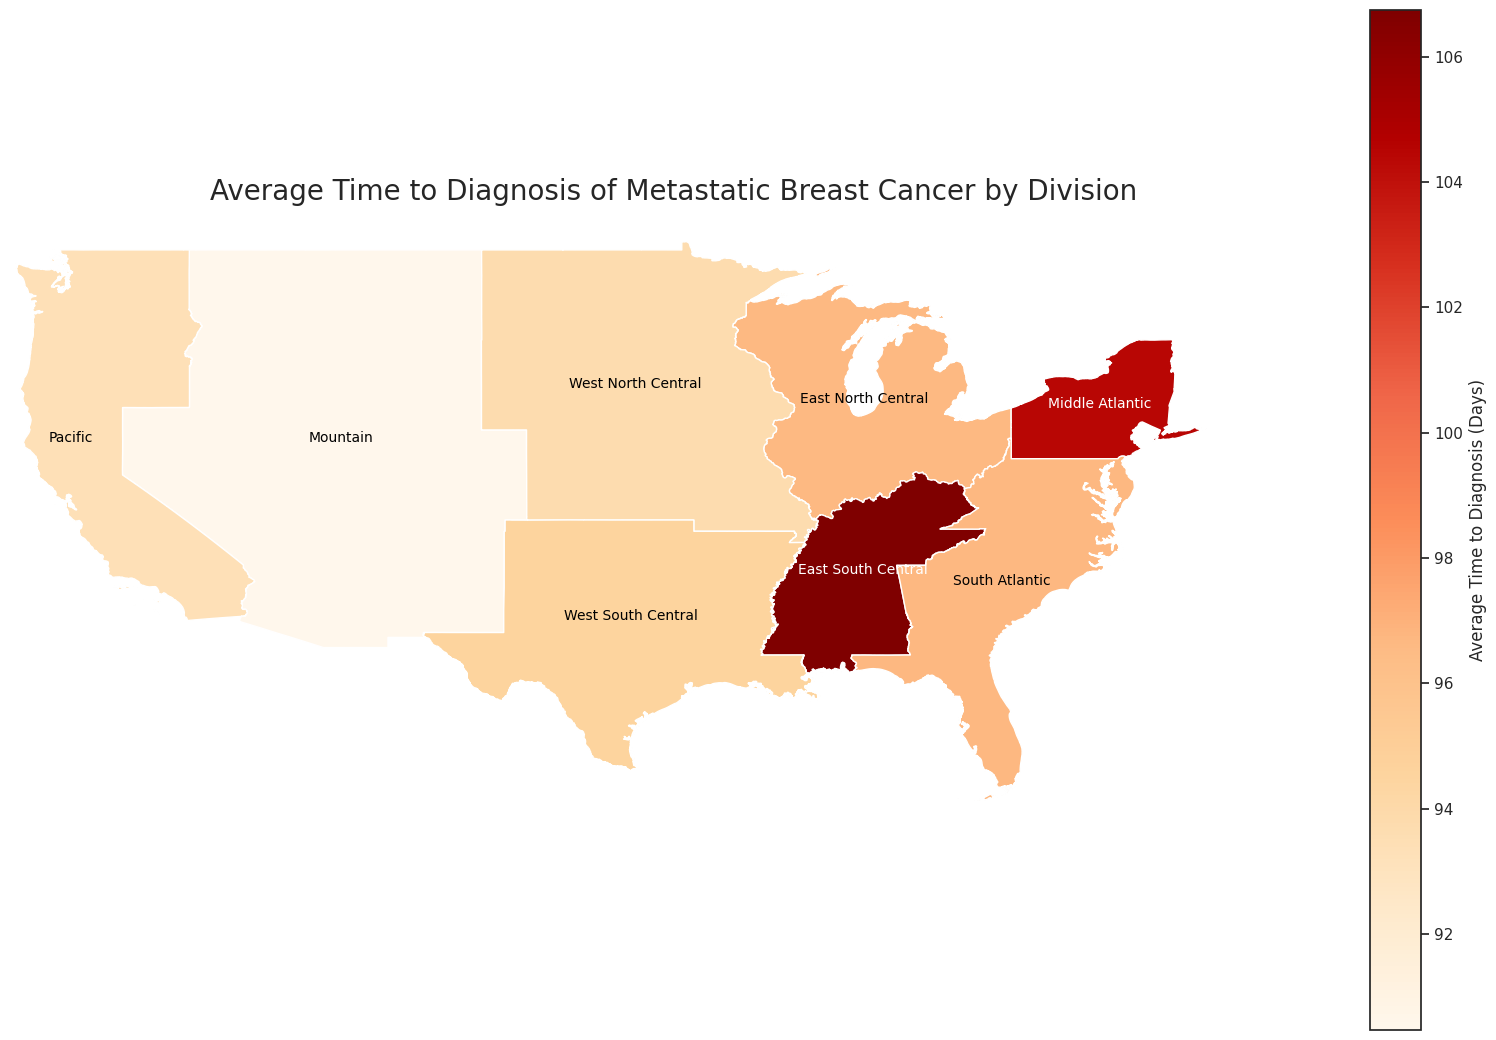

In [137]:
# Set up the figure and axis with a large size
fig, ax = plt.subplots(1, 1, figsize=(20, 12))  # Large figure size

# Set custom x and y limits for the contiguous US
ax.set_xlim([-125, -66])  # Approximate longitude bounds for the US
ax.set_ylim([24, 50])     # Approximate latitude bounds for the US

# Plot the divisions and color by the average TARGET variable
merged_division_map.plot(column=TARGET, ax=ax, legend=False,
                          cmap='OrRd', missing_kwds={'color': 'lightgrey', 'label': 'No Data'})

# Set the aspect ratio to equal to maintain the correct proportions
ax.set_aspect('equal')

# Add title above the map
ax.set_title('Average Time to Diagnosis of Metastatic Breast Cancer by Division', fontsize=20, pad=20)
ax.set_axis_off()

# Create a color bar beside the map
norm = mpl.colors.Normalize(vmin=merged_division_map[TARGET].min(), vmax=merged_division_map[TARGET].max())
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='OrRd'), ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("Average Time to Diagnosis (Days)", fontsize=12)

# Add division labels
for _, row in merged_division_map.iterrows():
    division_name = row['Division']  # Column with division names
    centroid = row['geometry'].centroid

    # Place the Pacific Division label to the left of the Mountain Division
    if division_name == 'Pacific':
        # Manually adjust the position based on where the Mountain Division is located
        mountain_centroid = merged_division_map.loc[merged_division_map['Division'] == 'Mountain', 'geometry'].values[0].centroid
        ax.text(mountain_centroid.x - 12, mountain_centroid.y, division_name, fontsize=10, ha='center', color='black')  # Adjusted coordinates
    
    elif (division_name == 'East South Central' or division_name == 'Middle Atlantic'):
        ax.text(centroid.x, centroid.y, division_name, fontsize=10, ha='center', color='white')
    else:
        ax.text(centroid.x, centroid.y, division_name, fontsize=10, ha='center', color='black')

# Show the plot
plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.05)
plt.show()

# By Region

Calculate average by Region and a mapping:

In [123]:
avg_region_target = train.groupby('Region')[TARGET].mean().reset_index()

Map Region to states:

In [124]:
state_to_region = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT'],
    'Midwest': ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI'],
    'South': ['DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'SC', 'TN', 'VA', 'WV', 'DC', 'AL', 'AR', 'OK', 'TX'],
    'West': ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']
}

region_to_states = {state: region for region, states in state_to_region.items() for state in states}

us_states['Region'] = us_states['patient_state'].map(region_to_states) 

# Dissolve the GeoDataFrame by Region
regions_geo = us_states.dissolve(by='Region', as_index=False)

# Create map by region using avg_region_target 
merged_region_map = regions_geo.merge(avg_region_target, on='Region', how='left')

Plot target (metastatic diagnosis period) by Region:

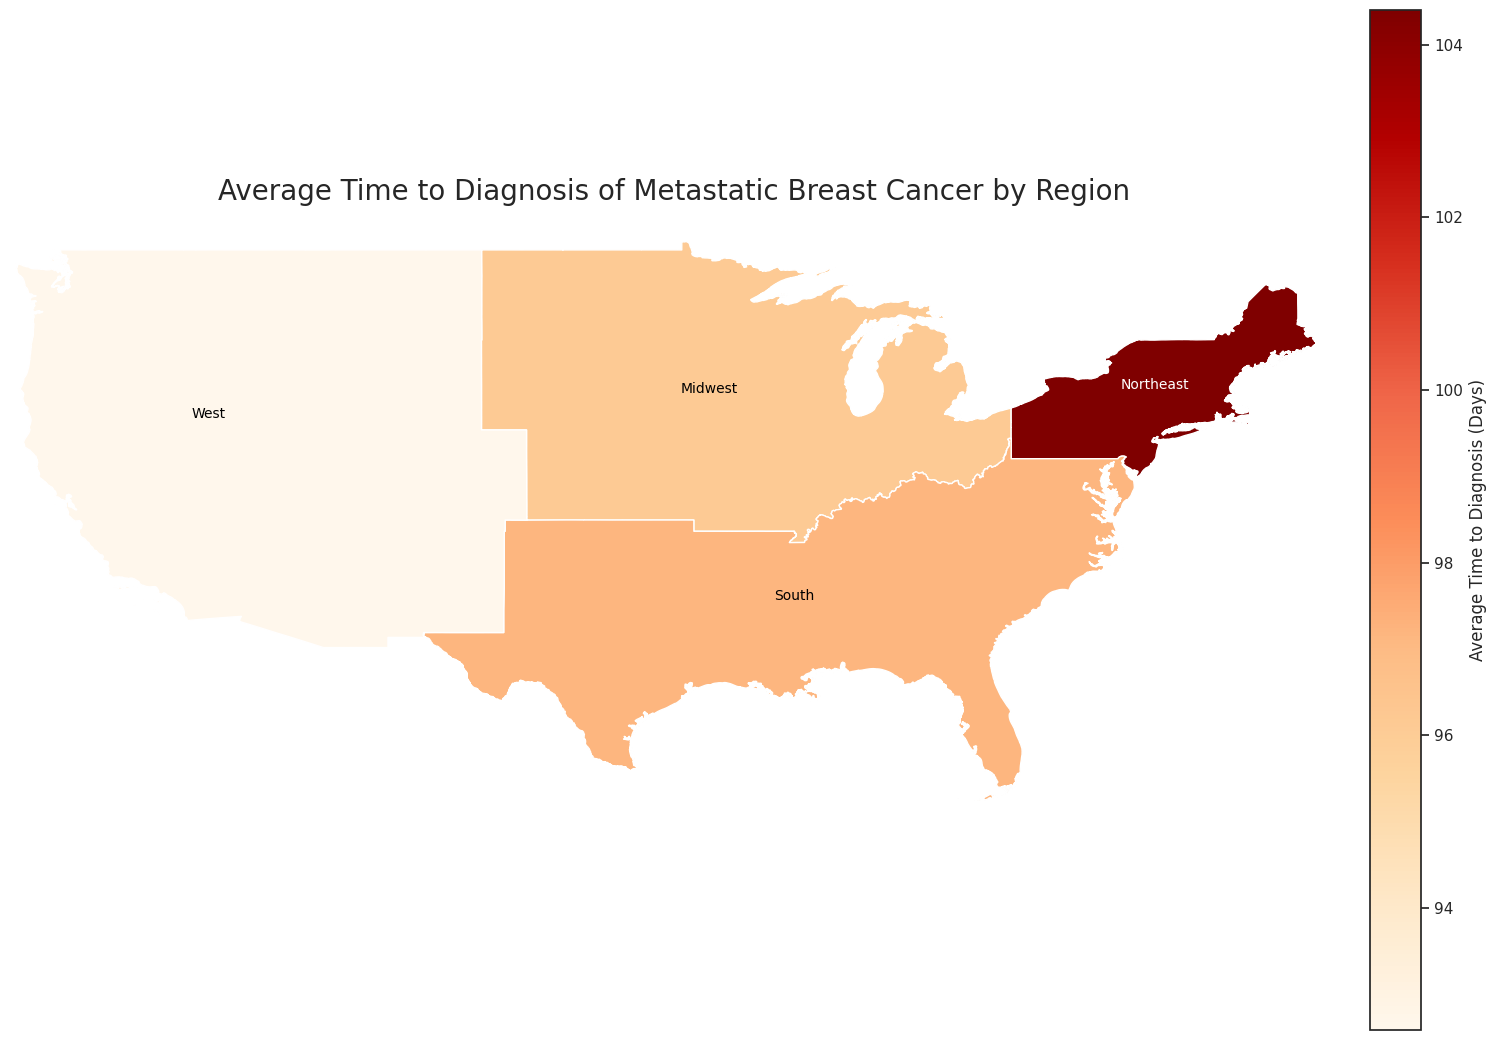

In [146]:
# Set up the figure and axis with a large size
fig, ax = plt.subplots(1, 1, figsize=(20, 12))  # Large figure size

# Set custom x and y limits for the contiguous US
ax.set_xlim([-125, -66])  # Approximate longitude bounds for the US
ax.set_ylim([24, 50])     # Approximate latitude bounds for the US

# Plot the divisions and color by the average TARGET variable
merged_region_map.plot(column=TARGET, ax=ax, legend=False,
                          cmap='OrRd', missing_kwds={'color': 'lightgrey', 'label': 'No Data'})

# Set the aspect ratio to equal to maintain the correct proportions
ax.set_aspect('equal')

# Add title above the map
ax.set_title('Average Time to Diagnosis of Metastatic Breast Cancer by Region', fontsize=20, pad=20)
ax.set_axis_off()

# Create a color bar beside the map
norm = mpl.colors.Normalize(vmin=merged_region_map[TARGET].min(), vmax=merged_region_map[TARGET].max())
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='OrRd'), ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("Average Time to Diagnosis (Days)", fontsize=12)

# Add division labels
for _, row in merged_region_map.iterrows():
    region_name = row['Region']  # Column with division names
    centroid = row['geometry'].centroid
    
    if region_name == 'Northeast':
        ax.text(centroid.x, centroid.y, region_name, fontsize=10, ha='center', color='white')
    elif region_name == 'West':
        ax.text(centroid.x + 15, centroid.y - 10, region_name, fontsize=10, ha='center', color='black')
    else:
        ax.text(centroid.x, centroid.y, region_name, fontsize=10, ha='center', color='black')

# Show the plot
plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.05)
plt.show()

# Split to numerical and categorical features

In [ ]:
TARGET = 'metastatic_diagnosis_period'
NUMERIC_COLS = [f for f in train._get_numeric_data().columns if f!= TARGET]
CAT_COLS     = list(test.drop(NUMERIC_COLS, axis = 1))

NUMERIC_AND_TARGET_COLS = NUMERIC_COLS.copy()
NUMERIC_AND_TARGET_COLS.append(TARGET)

CAT_AND_TARGET_COLS = CAT_COLS.copy()
CAT_AND_TARGET_COLS.append(TARGET)

In [ ]:
print(NUMERIC_COLS)
print('\nThere are ',len(NUMERIC_COLS),' numerical input variables')

In [ ]:
print(CAT_COLS)
print('\nThere are ',len(CAT_COLS),' categorical input variables')

## Numerical features

### Univariate plots - comparison of train vs test datasets

Check if numerical input variables are similar across the training and test datasets:

In [ ]:
def plot_numeric():
    palette = ['#007bff', '#28a745', '#ffc107', '#fd7e14',
               '#343a40', '#6c757d', '#17a2b8', '#dc3545']
    features = test.columns
    n_bins = 50
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }

    columns = NUMERIC_COLS
    n_cols = 3
    n_rows = math.ceil(len(columns)/n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
    ax = ax.flatten()

    for i, column in enumerate(columns):
        plot_axes = [ax[i]]
        sns.kdeplot(
            train[column], label='Train',
            ax=ax[i], color=palette[0]
        )

        sns.kdeplot(
            test[column], label='Test',
            ax=ax[i], color=palette[1]
        )

        # titles
        ax[i].set_title(f'{column} Distribution');
        ax[i].set_xlabel(None)

        # remove axes to show only one at the end
        plot_axes = [ax[i]]
        handles = []
        labels = []
        for plot_ax in plot_axes:
            handles += plot_ax.get_legend_handles_labels()[0]
            labels += plot_ax.get_legend_handles_labels()[1]
            plot_ax.legend().remove()

    for i in range(i+1, len(ax)):
        ax[i].axis('off')

    fig.suptitle(f'Dataset Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25, y=1.00)
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.00), fontsize=25, ncol=3)
    plt.tight_layout()

In [ ]:
plot_numeric()

The chart shows that the numeric input variables across the training and test datasets are similar.

### Correlations

Show correlations of all input variables vs the target variable:

In [ ]:
correlations_numerical = train[NUMERIC_AND_TARGET_COLS].corr()

for index, value in zip(correlations_numerical.index, round(correlations_numerical[TARGET],3)):
    print(f"{index}: {value}")
    
# The code below prints the whole correlation matrix but not used as the output is too large:
# correlations = train[NUMERIC_AND_TARGET_COLS].corr()
# print(correlations)

Filter to correlations greater than 0.1 in absolut value:

In [ ]:
threshold = 0.03
filtered_correlations_numerical = correlations_numerical[abs(correlations_numerical[TARGET]) >= threshold]


for index, value in zip(filtered_correlations_numerical.index, filtered_correlations_numerical[TARGET]):
    print(f"{index}: {value}")

Most variables are uncorrelated with the target (-0.03 < correlation < 0.03), the variable with the highest correlation in absolute value (-0.055) is patient age.

### Correlation heat map

The correlation heatmap is shown below. It shows that there are some highly correlated variables which are all related to average temperature.

In [ ]:
plt.figure(figsize=(15, 12)) 
sns.heatmap(correlations_numerical, cmap = 'coolwarm')

### Pair plots

Pair plots for selected variables of the training dataset. The diagonals show the distribution of single variables.

In [ ]:
sns.pairplot(train[['patient_age', 'bmi', 'home_ownership', 'density', 'metastatic_diagnosis_period']])

The pairplots do not show strong relationship between the target variable and any input variable. This is not surprusing, we have seen that the correlations are very low.

## Categorical features

## Univariate plots

In [ ]:
def plot_cat(limit_unique=10):
    selectcols = train[CAT_COLS].nunique()<=limit_unique
    cols_ = selectcols[selectcols].index.to_list()
    n_cols = len(cols_)
    fig, ax = plt.subplots(n_cols, 2, figsize=(12, 6 * n_cols))
    for i, coluna in enumerate(cols_):    
        sns.countplot(x=train[coluna], ax=ax[i, 0])
        ax[i, 0].set_title(f'{coluna}')
        ax[i, 0].set_ylabel('Count')
        ax[i, 0].set_xlabel(coluna)
        ax[i, 0].tick_params(axis='x', labelrotation=45)

        for container in ax[i, 0].containers:
            ax[i, 0].bar_label(container, fmt='%d', label_type='center')

        s1 = train[coluna].value_counts()        

        textprops = {
            'size':8, 
            'weight': 'bold', 
            'color':'white'
        }

        ax[i, 1].pie(s1,
            autopct='%1.f%%',
            pctdistance=0.8, 
            textprops=textprops,
            labels=train[coluna].value_counts().index
        )    
        ax[i, 1].set_title(f'% {coluna}')

    plt.tight_layout()
    plt.show()
    # ax = sns.countplot(x=train['patient_race'])
    # for container in ax.containers:
    #     ax.bar_label(container, fmt='%d', label_type='center')

In [ ]:
plot_cat()

The charts show that some variables (*patient_age* and *metastatic_novel_treatment_type*) have the same value for all patients. These features are useless for the regression and should be dropped from the dataset (see Feature selection section). 

## Correlations

For categorical variables we get an error message when trying to calculate the correlation with the target variable which is numerical. 

On the other hand, in addition to the error messagre we also get a link to a tutorial to solve the issue with on hot encoding: [https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding]

I followed the approach below for most categical variables (excluded those that have more than 10 unique values as those are descriptions that require additional pre-processing, see Feature selection section).

In [ ]:
# Exclude categorical variables that have more than 10 values:
limit_unique = 10
train_CAT_COLS = train[CAT_COLS]
CAT_COLS_filtered = train[CAT_COLS].nunique() <= limit_unique
filtered_train_CAT_COLS = train_CAT_COLS.loc[:, CAT_COLS_filtered]

# Replace NaN values by zeros so that we can calculate correlations:
filtered_train_CAT_COLS.fillna(0, inplace=True)

# One hot encoding of categorical variables:
filtered_train_one_hot_CAT_COLS = pd.get_dummies(filtered_train_CAT_COLS)

# Add target variable to the dataframe:
filtered_train_one_hot_CAT_COLS[TARGET] = train[TARGET]

print(filtered_train_one_hot_CAT_COLS)

In [ ]:
correlations_categorical = filtered_train_one_hot_CAT_COLS.corr()

for index, value in zip(correlations_categorical.index, round(correlations_categorical[TARGET],3)):
    print(f"{index}: {value}")

These correlations are still relatively low with the higheest absolut values observed for *payer_type_0* (-0.073) and *payer_type_COMMERCIAL* (0.053) suggesting that the payer type has some explanatory power.


## Correlation heatmaps

Now we prepare the correlation heatmap similar to numererical variables:

In [ ]:
plt.figure(figsize=(15, 12)) 
sns.heatmap(correlations_categorical, cmap = 'coolwarm')

## Pair plots

The pair plots between the input and target variables is shown below:

In [ ]:
sns.pairplot(filtered_train_one_hot_CAT_COLS[['Region_Midwest','Region_Northeast','Region_South', 'Region_West', TARGET]])

### Facet grid

A facet grid is shown below showing the distribution of the target by race and region. It shows some differences in the distribution of the diagnosis period (e.g. shorter for Hispanic and Asian people in the Midwest region).

In [ ]:
sns.set(style="whitegrid")
g = sns.FacetGrid(train, col="Region", hue="Region", col_wrap=4, height=4)
g.map(sns.scatterplot, "patient_race", TARGET)
g.add_legend()

## Target

The distribution of the target variable is shown below:

In [ ]:
sns.histplot(train[TARGET],kde=True);

We can see that there are lots of instances where the target variable is zero, we calculate the number and proportion of such instances.

In [ ]:
num_rows_target_zero = (train[TARGET] == 0).sum()
proportion_target_zero = (train[TARGET] == 0).mean()

print("Proportion of rows where 'a' equals 1:", num_rows_target_zero)
print("Number of rows where 'a' equals 0:", round(proportion_target_zero,3)*100, '%')

## Data preprocessing

- Replace low occurence values with 'Other code'. 
- Low occurence values are determined based on the threshold which is set to 3. 

In [ ]:
COLS_LOW_OCCURRENCE = ['metastatic_cancer_diagnosis_code',
                       'breast_cancer_diagnosis_desc', 
                       'breast_cancer_diagnosis_code']
class ReplaceLowOccurrence(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, threshold=3):
        self.columns = columns
        self.threshold = threshold

    def fit(self, X, y=None):
        self.low_occurrence_values_ = {}
        for col in self.columns:
            self.low_occurrence_values_[col] = (X[col].value_counts() <= self.threshold)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            low_occurrence_values_col = self.low_occurrence_values_[col]
            X_copy.loc[X_copy[col].isin(low_occurrence_values_col[low_occurrence_values_col].index), col] = 'Other Code'
        return X_copy

Fill null values with:
- 'None' (categorical values)
- the mean (numerical values)

In [ ]:
def NullFill(df):
    x_copy =df.copy()
    for c in CAT_COLS:                       
        x_copy[c] = x_copy[c].infer_objects(copy=False).fillna('None')
    
    for c in NUMERIC_COLS:
        x_copy[c] = x_copy[c].infer_objects(copy=False).fillna(x_copy[c].mean())
                
        
    return x_copy

NullImputer = FunctionTransformer(NullFill)

Data preprocessing of the *breast_cancer_diagnosis_desc* column. 

Certain values are replaced, e.g. *'malig'* is replaced by an empty string, *'unsp'* is replaced by *'unspecified'* etc.

In [ ]:
# thanks @iqbalsyahakbar
def desc_cleaner(x):
    x_copy = x.copy()
    
    rep = {
        'malig ' : '',
        'malignant ' : '',
        'neoplm ' : '',
        'neoplasm ' : '',
        'unsp ' : 'unspecified ',
        'ovrlp' : 'overlapping',
        'sites' : 'site',
        'site,' : 'site',
        'breast,' : 'breast',
        'areola,' : 'areola',
        '(female),' : 'female',        
        'of ' : '',
        ' and ' : ' ',
        '-' : ' '
    }
    rep = dict((re.escape(k), v) for k, v in rep.items())
    pattern = re.compile("|".join(rep.keys()))

    x_copy['breast_cancer_diagnosis_desc'] = x_copy.breast_cancer_diagnosis_desc.astype('str').apply(
        lambda x: pattern.sub(lambda m: rep[re.escape(m.group(0))], x.lower())
    )
    
    return x_copy

DescCleaner = FunctionTransformer(desc_cleaner)

In this minimal dataset we drop as many variables as possible:
- *patient_gender* and *metastatic_first_treatment_type*) from the training dataset as these have the same value for all patients
- *metastatic_first_novel_treatment* (only 10 non-blanks in training dataset)
- features which are redundant as they represent the population distribution and it adds up to 100% (e.g. if proportion of females used then proportion of males is redundant)
- *breast_cancer_diagnosis_desc* (breast cancer code used)
- feautures which represent population distributions in the area such as age, income, education, race (instead just the median value or one representative value used e.g. *education_college_or_above*)
- other features with very little correlation (<0.01) with the target, e.g. housing units
- average temperatures (as climate risk not deemed to have strong explanatory power)

In [ ]:
age_population_distribution = [col for col in train.columns if col.startswith('age')].remove('age_median')
type(age_population_distribution)

In [ ]:
COLS_TO_DROP                = ['metastatic_first_novel_treatment_type', 'metastatic_first_novel_treatment','patient_gender', 
                               'breast_cancer_diagnosis_desc', 
                                'male', 'never_married', 
                               'home_ownership', 'housing_units', 'rent_burden',
                               'farmer',
                               'veteran']

type(COLS_TO_DROP  )

age_population_distribution = [col for col in train.columns if col.startswith('age')]
age_population_distribution.remove('age_median')
income_population_distribution = [col for col in train.columns if col.startswith('income')]
income_population_distribution.remove('income_individual_median')
education_population_distribution = [col for col in train.columns if col.startswith('education')]
education_population_distribution.remove('education_college_or_above')
race_population_distribution = [col for col in train.columns if col.startswith('race')]
race_population_distribution.remove('race_white')
average_temperature = [col for col in train.columns if col.startswith('Average')]

#other_cols_to_drop = ['age', 'Region']

COLS_TO_DROP.extend(age_population_distribution)
COLS_TO_DROP.extend(income_population_distribution)
COLS_TO_DROP.extend(education_population_distribution)
COLS_TO_DROP.extend(race_population_distribution)
COLS_TO_DROP.extend(average_temperature)
#COLS_TO_DROP.extend(other_cols_to_drop)

def dropCols(df):
    x_copy = df.copy()
    return x_copy.drop(COLS_TO_DROP,axis=1)

DropColsTransformer = FunctionTransformer(dropCols)

Evaluate model performance on the training datasret with cross-validation (5-fold):

In [ ]:
SEED = 42
splits = 5
kf = KFold(n_splits = splits, random_state = SEED, shuffle = True)
def score_model(estimator, label = ''):
    

    X = train.copy()
    y = X.pop(TARGET)
    
    val_predictions = np.zeros((len(X)))
    test_predictions = np.zeros((len(test)))
    train_scores, val_scores= [], []    
    

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):

        model = clone(estimator)

        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y.iloc[train_idx].reset_index(drop = True)

        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y.iloc[val_idx].reset_index(drop = True)
           
        model.fit(X_train, y_train)
            
        train_preds = model.predict(X_train).clip(0,None)
        val_preds = model.predict(X_val).clip(0,None)

        val_predictions[val_idx] += val_preds
        test_predictions += model.predict(test).clip(0,None) / kf.get_n_splits()
        
        train_score = mean_squared_error(y_train, train_preds, squared = False)
        val_score = mean_squared_error(y_val, val_preds, squared = False)

        train_scores.append(train_score)
        val_scores.append(val_score)
        print(f'{fold+1} - RMSE: {val_score}')
        
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')

    return val_scores, val_predictions, test_predictions

# Model training 

In [ ]:
scores, oof, test_preds = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

In [ ]:
scores['lgbm_Tweedie'], oof['lgbm_Tweedie'],test_preds['lgbm_Tweedie'] = score_model(make_pipeline(                                                         
                                                         DescCleaner,
                                                         NullImputer,
                                                         ReplaceLowOccurrence(COLS_LOW_OCCURRENCE),
                                                         MEstimateEncoder(cols=CAT_COLS),
                                                         DropColsTransformer,
                                                         LGBMRegressor(random_state=SEED,
                                                                       n_estimators=37,
                                                                       tweedie_variance=1.1,
                                                                       verbosity=-1,
                                                                       objective="tweedie", 
                                                                       metric="rmse")),'LGBM_TWEEDIE')

In [ ]:
scores['lgbm_regression'], oof['lgbm_regression'],test_preds['lgbm_regression'] = score_model(make_pipeline(NullImputer,
                                                         ReplaceLowOccurrence(COLS_LOW_OCCURRENCE),
                                                         MEstimateEncoder(cols=CAT_COLS),
                                                         DropColsTransformer,
                                                         LGBMRegressor(random_state=SEED,
                                                                       n_estimators=40,
                                                                       verbosity=-1,
                                                                       objective="regression", 
                                                                       metric="rmse")),'LGBM_Reg')

In [ ]:
CAT_COLS_CB = [f for f in CAT_COLS if f not in COLS_TO_DROP]
scores['catboost_bernoulli'], oof['catboost_bernoulli'],test_preds['catboost_bernoulli'] = score_model(make_pipeline(
                                                         DescCleaner,
                                                         NullImputer,
                                                         ReplaceLowOccurrence(COLS_LOW_OCCURRENCE),
                                                         DropColsTransformer,
                                                         CatBoostRegressor(random_state=SEED,
                                                                       n_estimators=1200,
                                                                       verbose=0,
                                                                       cat_features=CAT_COLS_CB,
                                                                       bootstrap_type='Bernoulli'),
                                                                        ),'CatBoost_bernoulli')

In [ ]:
scores['catboost'], oof['catboost'],test_preds['catboost'] = score_model(make_pipeline(NullImputer,
                                                         ReplaceLowOccurrence(COLS_LOW_OCCURRENCE),
                                                         DropColsTransformer,
                                                         CatBoostRegressor(random_state=SEED,
                                                                       verbose=0,
                                                                       n_estimators=1200,
                                                                       cat_features=CAT_COLS_CB,
                                                                       bootstrap_type=None),
                                                                        ),'CatBoost')

# Evaluation

Calculate the weights for an ensemble model (linear combination of the stand-alone models with weights adding up to 1).

In [ ]:
model = Ridge(positive=True)
model.fit(oof,train[TARGET])
w = model.coef_
w /= w.sum()
display(w)

In [ ]:
ax = plt.subplot()
wplot = pd.DataFrame(w, list(oof))
wplot.plot(kind='pie',y=0,autopct='%1.2f%%',ax=ax)
ax.legend( bbox_to_anchor=(1.8, 1), loc='upper right');
ax.set_ylabel(None);

In [ ]:
scores['ensemble'] = mean_squared_error(train[TARGET],oof.to_numpy() @ w,squared=False)

Evaluation of model performance on the training data with 5-fold cross-validation. The evaluation shows that the model with the best performance is the ensemble model. 

In [ ]:
ax = scores.mean().sort_values(ascending=False).plot(kind='barh')
ax.bar_label(ax.containers[0],label_type='center',color='white',fontweight='bold')
ax.patches[-1].set_facecolor('green');

# Submission

Submitting the ensemble model (predition is calculated using weights *w* and the predictions of the stand-alone models):

In [ ]:
predictions = test_preds.to_numpy() @ w

Write predictions in the submission dataframe *sub*: 

In [ ]:
sub[TARGET] = predictions.clip(0,None).round().astype(int)

Create submission file in .csv format from the submission dataframe *sub*:

In [ ]:
sub.to_csv('submission.csv',index=False)

In [ ]:
print(predictions)

In [ ]:
print(sub)